In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

В данном уроке мы познакомимся с практической реализацией многоруких и контекстуальных бандитов. 

**Задача**: Название пошло от "одноруких бандитов". Так называли игровые автоматы с ручками-рычагами, потянув за которые можно получить выигрыш. Таких автоматов много, но вы заранее не знаете, какой автомат дает наибольший выигрыш. Проблема "многоруких бандитов" заключается в том, чтобы найти автомат с максимальным выигрышем с минимальными потерями.

В нашем случае бандитами являются стратегии предсказания цен, а выигрыш - какая-то целевая метрика (маржа, например)

Как нам сравнивать эффективность стратегий?
$$
R_{opt} - \text{оптимальная награда} \\
R_{strategy} - \text{награда за выбранную нами стратегию} \\
\mathrm{regret} = R_{opt} - R_{strategy} - \text{недополученная прибыль/метрика}
$$

# Contextual bandits

Для знакомства с констекстуальными бандитами мы будем использовать 2 библиотеки. Установим ее

Котекстуальные бандиты (тажке известны как) многорукие бандиты с ковариатами или с асоциативным обучением с подкреплением и представляют проблему аналогичную многоруким бандитам, но с той разницей, что дополнительная информация (или ковариаты) доступна на каждый итерации и может использоваться для выбора ручки. Вознаграждения тоже зависят от ковариатов.

Сложность возникает, когда данные генерируются итеративно следующим образом:
На каждой итерации мир/env создает наблюдение, состоящее из набора ковариат $X$ фиксированной размерности ($X$ - некоторое описание шагов, в которые был сделан выбор, и неекоторое описание действий), вектора вознаграждения $R$, который является стохастическим, но тоже зависит от ковариатов), $m$ - количество "ручек".

Аген должен выбрать "руку" или "метку" для наблюдения среди набора "ручек". В ответ среда показывает нам награду за выбранную ручку. Цель состоит в том, чтобы создать стратегию, которая миксимизирует вознаграждение, получаемое агентом. Ручки могут со временем пропадать или могут появляться новые.

Постановка похожа на многоклассовую классификацию, но с отсутствующими правильными метками.Это очень похоже на ситуацию в онлайн-рекламе, когла мы знаешь, что пользователь нажал на 1 конкретную рекламную акцию, но не знаем, как бы он повел себя в случаешь других рекламных промо. 

Будем использовать "игрушечную" задачу, в который нам известна награда за все действия, чтобы познакомиться с методом

In [18]:
from space_bandits.toy_problem import get_cust_reward, get_customer, get_rewards

В данном случаем мы работаем с 2-мя группами клиентов. Каждый клиент описывается 2-мя характеристиками: H, ARPU

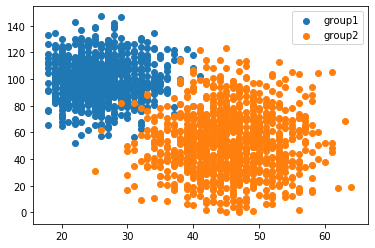

In [19]:
group1 = [get_customer(ctype=1)[1] for x in range(1000)]
group2 = [get_customer(ctype=2)[1] for x in range(1000)]
plt.scatter([x[0] for x in group1], [x[1] for x in group1], label='group1');
plt.scatter([x[0] for x in group2], [x[1] for x in group2], label='group2');
plt.legend();

У нас есть клиенты (`cutomers`) и награды (`rewards`) которые представляют собой вектор из 3 возможных значений. По сути это 3 акции, которая компания может предложить. Первая - лучше всего подходит первой группе, третья лучше всего подходит второй группе, а вторая акция не является оптимально ни для одной из 2х групп. 

Контекстуальные бандиты очень изящно обрабатывают такое поведение, так как они моделуют генерацию вознагражения как случайный процесс.

Чтобы убедиться, что генерация вознаграждений работает правильно, давайте посчитаем среднее вознаграждение для каждой из групп.

In [20]:
customers = [get_customer(ctype=1) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 1 expected rewards: (100000 samples)', rewards.mean(axis=0))

customers = [get_customer(ctype=2) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
rewards.mean(axis=0)
print('group 2 expected rewards: (100000 samples)', rewards.mean(axis=0))

group 1 expected rewards: (100000 samples) [8.9978  2.49625 1.958  ]
group 2 expected rewards: (100000 samples) [ 2.4983   2.47425 20.086  ]


Если мы подумаем об этом в рамках проблемы о динмическом ценообразованиее, то можно представить следующее: пусть имеются группы покупателей, который пришли на сайти, чтобы купить опеределнный `SKU`. Мы не знаем количества групп, не знаем их точного распределения, и не знаем какой покупатель какой группе принадлежит, но хотели бы это установить в будущем. Однако у нас есть некоторые описательные характеристики для пользоваелей в виде, например, среднего чека за покупку или среднее количество `SKU`, которое они купили за последнюю покупку итд. Затем для каждого покупателя мы можем предложить несколько моделей, будем случайно выбирать модель, брать предсказание выданное для пользователя, ставить предложенную моделью цену и смотреть награду за нее в виде либо купил/не купил или значение по какой цене покупатель в итоге купил товар. По сути мы можем выбрать такие модели, которые будут хорошо работать на определенных группах покупателей.

Посмотрим на наших сгенерированных покупателей `customers`

In [23]:
customers[:10]

[(2, (53, 61.27884094803353)),
 (2, (38, 50.88285900495397)),
 (2, (40, 34.25962987297904)),
 (2, (41, 36.07741738964068)),
 (2, (46, 46.62970623580589)),
 (2, (36, 24.791053674847035)),
 (2, (41, 21.59056238451975)),
 (2, (45, 48.070796167156416)),
 (2, (46, 49.07765937426515)),
 (2, (50, 29.27442814968552))]

Ну и посмотрим на награды `rewards`

In [24]:
rewards

array([[ 10,   0, 100],
       [  0,  25,   0],
       [  0,  25,   0],
       ...,
       [ 10,   0,   0],
       [ 10,   0,   0],
       [  0,  25,   0]])

На первом проходе мы будем использовать Байесовскую модель линейной регресси, которая напрямую сопоставляет функцию с ожидаемым вознаграждением с помощью линейных коеффициентов. По сути мы будем использовать онлайн-обучение: модель принимает решение - выбирает actiom (ручку), получает вознаграждение и затем делает это заново

Мы будем использовать линейную модель `LinearBandits` из `space_bandits`

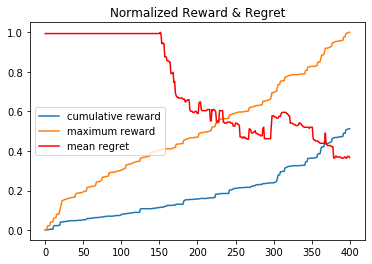

In [25]:
from space_bandits import LinearBandits
 
num_actions = 3 # num of available models (promo strategies)
num_features = 2 # num of features per customer

linear_model = LinearBandits(num_actions, num_features, initial_pulls=100)
optimal_choices = [None, 0, 2]

def iterate_model(model, optimal_choices, steps, records=None, plot_frequency=250, avg_length=150):
    """Goes through online learning simulation with model."""
    #these will track values for plotting
    if records is None:
        records = dict()
        records['timesteps'] = []
        records['c_reward'] = []
        records['cumulative_reward'] = 0
        records['m_reward'] = []
        records['maximum_reward'] = 0
        records['regret_record'] = []
        records['avg_regret'] = []
        start = 0
    else:
        start = records['timesteps'][-1]
    for i in range(start, start+steps):
        records['timesteps'].append(i)
        #generate a customer
        cust = get_customer()
        
        #generate customer decisions based on group
        reward_vec = get_rewards(cust)
        
        #prepare features for model
        context = np.array([cust[1]])
        best_choice = optimal_choices[cust[0]]
        
        #get reward for 'best' choice
        mx = reward_vec[best_choice]
        records['maximum_reward'] += mx
        records['m_reward'].append(records['maximum_reward'])
        
        # make and action
        action = model.action(context)
        
        #get reward for the action chosen by model
        reward = reward_vec[action]
        
        #regret is the opportunity cost of not choosing the optimal promotion
        regret = mx - reward
        records['regret_record'].append(regret)
        records['cumulative_reward'] += reward
        records['c_reward'].append(records['cumulative_reward'])
        model.update(context, action, reward)
        
        #plot occasionally
        if i <= avg_length:
            if i < avg_length:
                moving_avg=0
            else:
                moving_avg = np.array(records['regret_record']).mean()
            if i == avg_length:
                records['avg_regret'] = [moving_avg] * avg_length
        else:
            moving_avg = sum(records['regret_record'][-avg_length:])/avg_length
        records['avg_regret'].append(moving_avg)
        if i % plot_frequency == 0 and i > 0:
            c_rewardplt = np.array(records['c_reward'])/max(records['m_reward'])
            m_rewardplt = np.array(records['m_reward'])/max(records['m_reward'])
            regretplt = np.array(records['avg_regret'])/max(records['avg_regret'])
            plt.plot(records['timesteps'], c_rewardplt, label='cumulative reward')
            plt.plot(records['timesteps'], m_rewardplt, label='maximum reward')
            plt.plot(records['timesteps'], regretplt, color='red', label='mean regret')
            plt.title('Normalized Reward & Regret')
            plt.legend()
            plt.show()
    return records
            
records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=400)


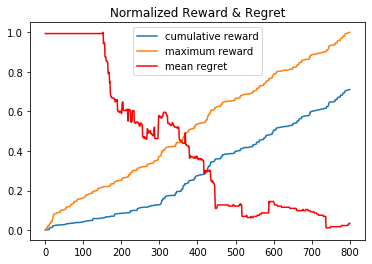

In [26]:
# from space_bandits import load_model
# linear_model.save('test_path.pkl')
# linear_model = load_model('test_path.pkl')

#continue training

records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=800, records=records)

Давайте теперь для модели построим разделяющую прямую, котоаря дели 2 облака покупателей, на основании моделирования

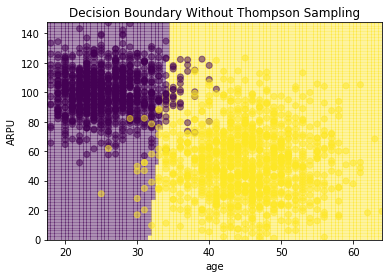

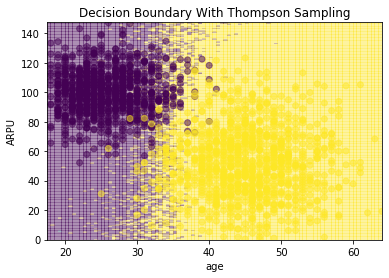

took  33.64  seconds.


In [27]:
def plot_decision_boundary(model, X, Y, h=1, scale=1., parallelize=True, title='decision boundary', thompson=False, classic=False, n_threads=-1, flip_colors=True):
    ftnames = X.columns[0], X.columns[1]
    X = X.values
    #model.fit(X[:, :2], Y)
    x_min = X[:, 1].min() - .5
    x_max = X[:, 1].max() + .5
    y_min = X[:, 0].min() - .5
    y_max = X[:, 0].max() + .5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    if classic:
        Z = model.classic_predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson, parallelize=parallelize)

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=.25)

    # Add the training points to the plot.
    if flip_colors:
        Y = np.where(np.array(Y)==1, 0, 1)
    plt.scatter(X[:, 1], X[:, 0], c=Y, alpha=.5);
    #plt.scatter(X[:, 1], X[:, 0], c='black', alpha=.1);


    plt.xlabel(ftnames[1])
    plt.ylabel(ftnames[0])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max());
    plt.title(title)
    plt.show()
    
    
from time import time
X = group1 + group2
Y = [1 for x in range(1000)] + [0 for x in range(1000)]
ages = [x[0] for x in X]
ARPUs = [x[1] for x in X]
as_df = pd.DataFrame()
as_df['ARPU'] = ARPUs
as_df['age'] = ages
X = as_df



plot_decision_boundary(linear_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling')

t1 = time()
plot_decision_boundary(linear_model, X, Y, h=.5, thompson=True, parallelize=True, n_threads=3, title='Decision Boundary With Thompson Sampling')
print('took ', round(time()-t1, 2), ' seconds.')

Видно, что с семлированием Томпсона граница несколько размыта (эффект градиента). Это связано с тем, что в тех регионах, где уверенности у модели нет, например, где группы клиентов пересекаются, семплирование Томпсона возвращает сочетание рекомендаций между 2-мя вариантами, и это позволяет оптимизировать модель с помощью будущих примеров. Таким образом семплирование Томпсона дает "умный" способ исследования.

Есть один интересный момент: в регионах где нет или очень мало покупателей (сэмплов) модель может рекоммендовать полхую рекламу (2 стратегия) так как она не знает, что для того региона эта модель не походит

Давайте теперь посмотрим на Бандитов, моделирующих награду с помощью нейронной сети `NeuralBandits`

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


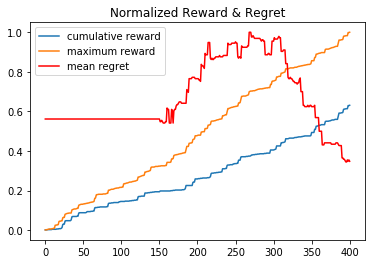

In [28]:
from space_bandits import NeuralBandits

num_actions = 3
num_features = 2
memory_size = 10000

neural_model = NeuralBandits(num_actions, num_features, initial_pulls=100, memory_size=memory_size, layer_sizes=[50, 12])
assert neural_model.data_h.memory_size == memory_size

records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=400)

In [29]:
records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=800)

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


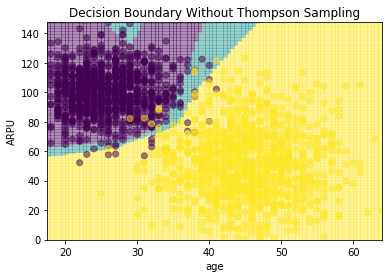

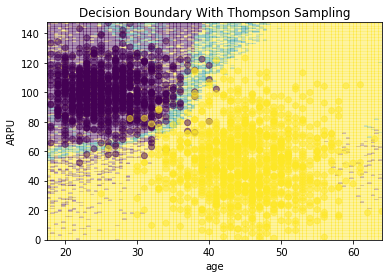

took  38.55807590484619


In [30]:
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling', n_threads=3)


t1 = time()
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=True, parallelize=True, title='Decision Boundary With Thompson Sampling', n_threads=3)
print('took ', time() - t1)

Как раз на картинке виден тот эффект "рекоммендации плохой для всех стратегии"

Есть еще одна библиотека для работы с контекстуальными бандитами

В целом она тоже очень популярная, но единственное ограничение это то, что награда может моделироваться только как дискретная и принимать значение только {0,1}. В целом такая библиотека тоже модет быть полезной для динамического ценообразования.

In [ ]:
from contextualbandits.online import (BootstrappedUCB, BootstrappedTS, LogisticUCB,
                                      SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, 
                                      ExploreFirst, ActiveExplorer, SoftmaxExplorer,
                                      )
